## Cookbook: Parallelized *STRUCTURE* analyses on unlinked SNPs

As part of the `ipyrad.analysis` toolkit we've created some convenience functions for easily distributing *STRUCTURE* analysis jobs on an HPC cluster, and for doing so in a programmatic and reproducible way. Importantly, *our workflow allows you to easily sample different distributions of unlinked SNPs among replicate analyses*, with the final inferred population structure summarized from a distribution of replicates. We also provide some simple interactive plotting functions to make barplots and slightly fancier figure, like below. 

![example-struct](https://rawgithub.com/dereneaton/ipyrad/master/tests/struct.svg)  

### A note on Jupyter/IPython
This is a Jupyter notebook, a reproducible and executable document. The code in this notebook is Python (2.7), and should be executed either in a jupyter-notebook, like this one, or in an IPython terminal. Execute each cell in order to reproduce our entire analysis. We make use of the `ipyparallel` Python library to distribute *STRUCTURE* jobs across processers in parallel. If that is confusing, see our [tutorial on using ipcluster with jupyter](). The example data set used in this analysis is from the [empirical example ipyrad tutorial](http://ipyrad.readthedocs.io/pedicularis_.html).

### Required software
You can easily install the required software for this notebook locally using `conda` by running the commented code below in a terminal. If you are working on an HPC cluster you **do not need** administrator privileges to install the software in this way, since it is only installed locally.

In [1]:
## conda install ipyrad -c ipyrad
## conda install structure -c ipyrad
## conda install clumpp -c ipyrad
## pip install toyplot

### Import Python libraries

In [2]:
import ipyrad.analysis as ipa      ## ipyrad analysis toolkit
import ipyparallel as ipp          ## parallel processing
import toyplot                     ## plotting library

### Parallel cluster setup
Start an `ipcluster` instance in a separate terminal, like below. An easy way to do this in a jupyter-notebook running on an HPC cluster is to go to your Jupyter dashboard, and click [new], and then [terminal], and run `ipcluster start` in that terminal. This will start a local cluster on the compute node you are connected to. See our [ipyparallel tutorial]() for further details. 

In [3]:
##
## ipcluster start --n=40
##

In [4]:
## get parallel client
ipyclient = ipp.Client()
print "Connected to {} cores".format(len(ipyclient))

Connected to 40 cores


### Enter input and output file locations

In [5]:
## the structure formatted file
strfile = "./analysis-ipyrad/pedicularis_outfiles/pedicularis.str"

## an optional mapfile, to sample unlinked SNPs
mapfile = "./analysis-ipyrad/pedicularis_outfiles/pedicularis.snps.map"

## the directory where outfiles should be written
workdir = "./analysis-structure/"

### Create a *Structure* Class object
Structure is kind of an old fashioned program that requires creating quite a few input files to run, which makes it not very convenient to use in a programmatic and reproducible way. To work around this we've created a convenience wrapper object to make it easy to submit Structure jobs and to summarize their results. 

In [6]:
## create a Structure object
struct = ipa.structure(name="test-1",
                       strfile=strfile, 
                       mapfile=mapfile,
                       workdir=workdir)

### Set parameter options for this object
Our Structure object will be used to submit jobs to the cluster. It has associated with it a name, a set of input files, and a large number of parameter settings. You can modify the parameters by setting them like below. You can also use tab-completion to see all of the available options, or print them like below. See the [full structure docs here](http://computing.bio.cam.ac.uk/local/doc/structure.pdf) for further details on the function of each parameter. In support of reproducibility, it is good practice to print both the mainparams and extraparams so it is clear which options you used. 

In [7]:
## set mainparams for object (you should run longer!)
struct.mainparams.burnin = 2000
struct.mainparams.numreps = 20000

## see all mainparams
print struct.mainparams

## see or set extraparams
print struct.extraparams

burnin               2000
extracols            0
label                1
locdata              0
mapdistances         0
markernames          0
markovphase          0
missing              -9
notambiguous         -999
numreps              20000
onerowperind         0
phased               0
phaseinfo            0
phenotype            0
ploidy               2
popdata              0
popflag              0
recessivealleles     0

admburnin            500
alpha                1.0
alphamax             10.0
alphapriora          1.0
alphapriorb          2.0
alphapropsd          0.025
ancestdist           0
ancestpint           0.9
computeprob          1
echodata             0
fpriormean           0.01
fpriorsd             0.05
freqscorr            1
gensback             2
inferalpha           1
inferlambda          0
intermedsave         0
lambda_              1.0
linkage              0
locispop             0
locprior             0
locpriorinit         1.0
log10rmax            1.0
log10rmin       

### Submit jobs to run on the cluster
The function `submit_structure_jobs()` distributes jobs to run on the cluster and load-balances the parallel workload. It takes a number of arguments. The first, `kpop`, is the number of populations. The second, `nreps`, is the number of replicated runs to perform. Each rep has a different random seed, and if you entered a mapfile for your Structure object then it will subsample unlinked snps independently in each replicate. The `seed` argument can be used to make the replicate analyses reproducible. The `extraparams.seed` parameter will be generated from this for each replicate. And finally, the `ipyclient` argument is for the parallel client that we created above. Using a simple for-loop we submit 20 replicate jobs to run at two different values of K. 

In [10]:
## a range of K-values to test
tests = [4, 5]

In [8]:
## submit batches of 20 replicate jobs for each value of K 
for kpop in tests:
    struct.submit_structure_jobs(kpop=kpop, 
                                 nreps=20, 
                                 seed=12345,
                                 ipyclient=ipyclient)

submitted 20 structure jobs [test-1-K-4]
submitted 20 structure jobs [test-1-K-5]


### Track progress until finished
You can check for finished results by using the `get_clumpp()` function, which tries to summarize the finished results files. If no results are ready it will simply print a warning message telling you to wait. If you want the notebook to block/wait until all jobs are finished then execute the `wait()` function of the ipyclient object, like below. 

In [13]:
## check for results files from this object
print struct.result_files

[]


In [ ]:
## block/wait until all jobs finished
ipyclient.wait() 

### Summarize replicates with CLUMPP
We ran 20 replicates per K-value hypothesis. We now need to concatenate and purmute those results so they can be summarized. For this we use the software clumpp. The default arguments to clumpp are generally good, but you can modify them the same as structure params, by accessing the `.clumppparams` attribute of your structure object. See the [clumpp documentation](https://web.stanford.edu/group/rosenberglab/software/CLUMPP_Manual.pdf) for more details. If you have a large number of samples (>50) you may wish to use the `largeKgreedy` algorithm (m=3) for faster runtimes. Below we run clumpp for each value of K that we ran structure on. You only need to tell the `get_clumpp_table()` function the value of K and it will find all of the result files given the Structure object's `name` and `workdir`.

In [28]:
## set some clumpp params
struct.clumppparams.m = 3               ## use largegreedy algorithm
struct.clumppparams.greedy_option = 1   ## test all possible orders
struct.clumppparams

c                         13
datatype                  0
every_permfile            0
greedy_option             1
indfile                   0
kpop                      5
m                         3
miscfile                  0
order_by_run              1
outfile                   0
override_warnings         0
permfile                  0
permutationsfile          0
permuted_datafile         0
popfile                   0
print_every_perm          0
print_permuted_data       0
print_random_inputorder   0
r                         20
random_inputorderfile     0
repeats                   1000
s                         2
w                         1

In [16]:
## run clumpp for each value of K
tables = {}
for kpop in tests:
    tables[kpop] = struct.get_clumpp_table(kpop)

mean scores across 20 replicates.
mean scores across 20 replicates.


### Sort the table order how you like it
This can be useful if, for example, you want to order the names to be in the same order as tips on your phylogeny. 

In [22]:
## custom sorting order
myorder = [
    "32082_przewalskii", "33588_przewalskii",
    "41478_cyathophylloides", "41954_cyathophylloides", 
    "29154_superba",
    "30686_cyathophylla", 
    "33413_thamno", "30556_thamno", 
    "35236_rex", 
    "40578_rex", "35855_rex",
    "39618_rex", "38362_rex",
]

print "custom ordering"
print tables[4].ix[myorder]

custom ordering
                             0       1       2       3
32082_przewalskii       0.0000  0.0000  1.0000  0.0000
33588_przewalskii       0.0000  0.0000  1.0000  0.0000
41478_cyathophylloides  0.0000  0.0000  0.0236  0.9764
41954_cyathophylloides  0.0000  0.0000  0.0238  0.9762
29154_superba           0.6792  0.0010  0.0094  0.3105
30686_cyathophylla      0.6482  0.0052  0.0083  0.3383
33413_thamno            0.3619  0.6347  0.0025  0.0009
30556_thamno            0.2973  0.7002  0.0015  0.0011
35236_rex               0.3021  0.6874  0.0034  0.0072
40578_rex               0.2051  0.7940  0.0005  0.0004
35855_rex               0.1914  0.8046  0.0009  0.0031
39618_rex               0.0000  1.0000  0.0000  0.0000
38362_rex               0.0000  1.0000  0.0000  0.0000


### A function for adding an interactive hover to our plots
The function automatically parses the table above for you. It can reorder the individuals based on their membership in each group, or based on an input list of ordered names. It returns the table of data as well as a list with information for making interactive hover boxes, which you can see below by hovering over the plots.  

In [23]:
def hover(table):
    hover = []
    for row in range(table.shape[0]):
        stack = []
        for col in range(table.shape[1]):
            label = "Name: {}\nGroup: {}\nProp: {}"\
                .format(table.index[row], 
                        table.columns[col],
                        table.ix[row, col])
            stack.append(label)
        hover.append(stack)
    return list(hover)

### Visualize population structure in barplots 
Hover over the plot to see sample names and info in the hover box. 

In [42]:
for kpop in tests:
    ## parse outfile to a table and re-order it
    table = tables[kpop]
    table = table.ix[myorder]
    
    ## plot barplot w/ hover
    canvas, axes, mark = toyplot.bars(
                            table, 
                            title=hover(table),
                            width=400, 
                            height=200, 
                            yshow=False,                            
                            style={"stroke": toyplot.color.near_black},
                            )


Name: 32082_przewalskii
Group: 0
Prop: 0.0 Name: 33588_przewalskii
Group: 0
Prop: 0.0 Name: 41478_cyathophylloides
Group: 0
Prop: 0.0 Name: 41954_cyathophylloides
Group: 0
Prop: 0.0 Name: 29154_superba
Group: 0
Prop: 0.6792 Name: 30686_cyathophylla
Group: 0
Prop: 0.6482 Name: 33413_thamno
Group: 0
Prop: 0.3619 Name: 30556_thamno
Group: 0
Prop: 0.2973 Name: 35236_rex
Group: 0
Prop: 0.3021 Name: 40578_rex
Group: 0
Prop: 0.2051 Name: 35855_rex
Group: 0
Prop: 0.1914 Name: 39618_rex
Group: 0
Prop: 0.0 Name: 38362_rex
Group: 0
Prop: 0.0 Name: 32082_przewalskii
Group: 1
Prop: 0.0 Name: 33588_przewalskii
Group: 1
Prop: 0.0 Name: 41478_cyathophylloides
Group: 1
Prop: 0.0 Name: 41954_cyathophylloides
Group: 1
Prop: 0.0 Name: 29154_superba
Group: 1
Prop: 0.001 Name: 30686_cyathophylla
Group: 1
Prop: 0.0052 Name: 33413_thamno
Group: 1
Prop: 0.6347 Name: 30556_thamno
Group: 1
Prop: 0.7002 Name: 35236_rex
Group: 1
Prop: 0.6874 Name: 40578_rex
Group: 1
Prop: 0.794 Name: 35855_rex
Group: 1
Prop: 0.8046 Name: 39618_rex
Group: 1
Prop: 1.0 Name: 38362_rex
Group: 1
Prop: 1.0 Name: 32082_przewalskii
Group: 2
Prop: 1.0 Name: 33588_przewalskii
Group: 2
Prop: 1.0 Name: 41478_cyathophylloides
Group: 2
Prop: 0.0236 Name: 41954_cyathophylloides
Group: 2
Prop: 0.0238 Name: 29154_superba
Group: 2
Prop: 0.0094 Name: 30686_cyathophylla
Group: 2
Prop: 0.0083 Name: 33413_thamno
Group: 2
Prop: 0.0025 Name: 30556_thamno
Group: 2
Prop: 0.0015 Name: 35236_rex
Group: 2
Prop: 0.0034 Name: 40578_rex
Group: 2
Prop: 0.0005 Name: 35855_rex
Group: 2
Prop: 0.0009 Name: 39618_rex
Group: 2
Prop: 0.0 Name: 38362_rex
Group: 2
Prop: 0.0 Name: 32082_przewalskii
Group: 3
Prop: 0.0 Name: 33588_przewalskii
Group: 3
Prop: 0.0 Name: 41478_cyathophylloides
Group: 3
Prop: 0.9764 Name: 41954_cyathophylloides
Group: 3
Prop: 0.9762 Name: 29154_superba
Group: 3
Prop: 0.3105 Name: 30686_cyathophylla
Group: 3
Prop: 0.3383 Name: 33413_thamno
Group: 3
Prop: 0.0009 Name: 30556_thamno
Group: 3
Prop: 0.0011 Name: 35236_rex
Group: 3
Prop: 0.0072 Name: 40578_rex
Group: 3
Prop: 0.0004 Name: 35855_rex
Group: 3
Prop: 0.0031 Name: 39618_rex
Group: 3
Prop: 0.0 Name: 38362_rex
Group: 3
Prop: 0.0 0 4 8 12 
 
 
 Save as .csv

Name: 32082_przewalskii
Group: 0
Prop: 0.0 Name: 33588_przewalskii
Group: 0
Prop: 0.0 Name: 41478_cyathophylloides
Group: 0
Prop: 0.0 Name: 41954_cyathophylloides
Group: 0
Prop: 0.0001 Name: 29154_superba
Group: 0
Prop: 0.7468 Name: 30686_cyathophylla
Group: 0
Prop: 0.5126 Name: 33413_thamno
Group: 0
Prop: 0.07 Name: 30556_thamno
Group: 0
Prop: 0.159 Name: 35236_rex
Group: 0
Prop: 0.1137 Name: 40578_rex
Group: 0
Prop: 0.0729 Name: 35855_rex
Group: 0
Prop: 0.0895 Name: 39618_rex
Group: 0
Prop: 0.0 Name: 38362_rex
Group: 0
Prop: 0.0 Name: 32082_przewalskii
Group: 1
Prop: 0.0 Name: 33588_przewalskii
Group: 1
Prop: 0.0 Name: 41478_cyathophylloides
Group: 1
Prop: 0.9749 Name: 41954_cyathophylloides
Group: 1
Prop: 0.9746 Name: 29154_superba
Group: 1
Prop: 0.2527 Name: 30686_cyathophylla
Group: 1
Prop: 0.278 Name: 33413_thamno
Group: 1
Prop: 0.0 Name: 30556_thamno
Group: 1
Prop: 0.0 Name: 35236_rex
Group: 1
Prop: 0.0059 Name: 40578_rex
Group: 1
Prop: 0.0005 Name: 35855_rex
Group: 1
Prop: 0.003 Name: 39618_rex
Group: 1
Prop: 0.0 Name: 38362_rex
Group: 1
Prop: 0.0 Name: 32082_przewalskii
Group: 2
Prop: 0.0 Name: 33588_przewalskii
Group: 2
Prop: 0.0 Name: 41478_cyathophylloides
Group: 2
Prop: 0.0 Name: 41954_cyathophylloides
Group: 2
Prop: 0.0 Name: 29154_superba
Group: 2
Prop: 0.0 Name: 30686_cyathophylla
Group: 2
Prop: 0.2051 Name: 33413_thamno
Group: 2
Prop: 0.3041 Name: 30556_thamno
Group: 2
Prop: 0.1544 Name: 35236_rex
Group: 2
Prop: 0.2057 Name: 40578_rex
Group: 2
Prop: 0.1365 Name: 35855_rex
Group: 2
Prop: 0.1052 Name: 39618_rex
Group: 2
Prop: 0.0 Name: 38362_rex
Group: 2
Prop: 0.0 Name: 32082_przewalskii
Group: 3
Prop: 0.0 Name: 33588_przewalskii
Group: 3
Prop: 0.0 Name: 41478_cyathophylloides
Group: 3
Prop: 0.0 Name: 41954_cyathophylloides
Group: 3
Prop: 0.0 Name: 29154_superba
Group: 3
Prop: 0.0005 Name: 30686_cyathophylla
Group: 3
Prop: 0.0039 Name: 33413_thamno
Group: 3
Prop: 0.6237 Name: 30556_thamno
Group: 3
Prop: 0.6821 Name: 35236_rex
Group: 3
Prop: 0.6698 Name: 40578_rex
Group: 3
Prop: 0.7902 Name: 35855_rex
Group: 3
Prop: 0.8012 Name: 39618_rex
Group: 3
Prop: 1.0 Name: 38362_rex
Group: 3
Prop: 1.0 Name: 32082_przewalskii
Group: 4
Prop: 1.0 Name: 33588_przewalskii
Group: 4
Prop: 1.0 Name: 41478_cyathophylloides
Group: 4
Prop: 0.0251 Name: 41954_cyathophylloides
Group: 4
Prop: 0.0254 Name: 29154_superba
Group: 4
Prop: 0.0 Name: 30686_cyathophylla
Group: 4
Prop: 0.0005 Name: 33413_thamno
Group: 4
Prop: 0.0023 Name: 30556_thamno
Group: 4
Prop: 0.0044 Name: 35236_rex
Group: 4
Prop: 0.005 Name: 40578_rex
Group: 4
Prop: 0.0 Name: 35855_rex
Group: 4
Prop: 0.0011 Name: 39618_rex
Group: 4
Prop: 0.0 Name: 38362_rex
Group: 4
Prop: 0.0 0 4 8 12 
 
 
 Save as .csv

### Make a slightly fancier plot and save to file

In [45]:
## save plots for your favorite value of K
table = struct.get_clumpp_table(kpop=5)
table = table.ix[myorder]

mean scores across 20 replicates.


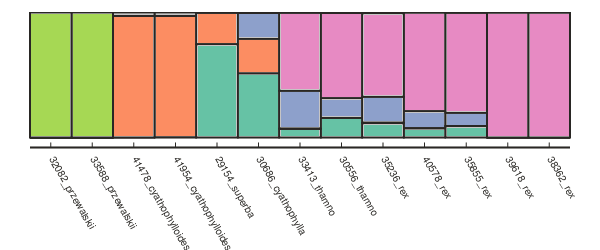

In [56]:
## further styling of plot with css 
style = {"stroke":toyplot.color.near_black, 
         "stroke-width": 2}

## build barplot
canvas = toyplot.Canvas(width=600, height=250)
axes = canvas.cartesian(bounds=("5%", "95%", "5%", "55%"))
axes.bars(table, title=hover(table), style=style)

## add names to x-axis
ticklabels = [i for i in table.index.tolist()]
axes.x.ticks.locator = toyplot.locator.Explicit(labels=ticklabels)
axes.x.ticks.labels.angle = -60
axes.x.ticks.show = True
axes.x.ticks.labels.offset = 10
axes.x.spine.style = style
axes.y.show = False
    
## options: uncomment to save plots. Only html retains hover.
import toyplot.svg
import toyplot.pdf
import toyplot.html
toyplot.svg.render(canvas, "struct.svg")
toyplot.pdf.render(canvas, "struct.pdf")
toyplot.html.render(canvas, "struct.html")

## show in notebook
canvas

### Calculating the best K 
I haven't gotten around to writing the code for this yet (contributors are welcome!). For now, I like using the site http://taylor0.biology.ucla.edu/structureHarvester/. It's great. Super easy. Zip up all the files in our structure directory, submit them to the site, and you're done. 

In [165]:
%%bash -s "$STRUCTDIR"

## creates zip dir of all files ending with _f
zip $1/structure-files.zip $1/*_f

updating: home/deren/Documents/ipyrad/tests/analysis_structure/K-3-rep-0_f (deflated 82%)
updating: home/deren/Documents/ipyrad/tests/analysis_structure/K-3-rep-1_f (deflated 82%)
updating: home/deren/Documents/ipyrad/tests/analysis_structure/K-3-rep-2_f (deflated 81%)
updating: home/deren/Documents/ipyrad/tests/analysis_structure/K-3-rep-3_f (deflated 82%)
updating: home/deren/Documents/ipyrad/tests/analysis_structure/K-3-rep-4_f (deflated 82%)
updating: home/deren/Documents/ipyrad/tests/analysis_structure/K-4-rep-0_f (deflated 80%)
updating: home/deren/Documents/ipyrad/tests/analysis_structure/K-4-rep-1_f (deflated 80%)
updating: home/deren/Documents/ipyrad/tests/analysis_structure/K-4-rep-2_f (deflated 80%)
updating: home/deren/Documents/ipyrad/tests/analysis_structure/K-4-rep-3_f (deflated 81%)
updating: home/deren/Documents/ipyrad/tests/analysis_structure/K-4-rep-4_f (deflated 80%)
  adding: home/deren/Documents/ipyrad/tests/analysis_structure/K-5-rep-0_f (deflated 80%)
  adding: 

### Copying this notebook to your computer/cluster
You can easily copy this notebook and then just replace my file names with your filenames to run your analysis. Just click on the [Download Notebook] link at the top of this page. Then run `jupyter-notebook` from a terminal and open this notebook from the dashboard.